# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

# Entregable 3


# Practico: Aprendizaje Supervisado


## Grupo 2. Integrantes:
* Aranda, Franco.
* Carazo, Fernando Diego
* Molina, Florencia
* Taié Mirón, Macarena. 


### Consigna


# Primera parte: Preparacion de los sets de datos


#### Consigna: Obtener un dataset de los tres pacientes y uno por cada paciente, dando como resultado 4 datasets. 

En base a lo visto hasta el momento, quizás sea mas predecible el estado pre-ictal separando el análisis por paciente. Vamos a evaluar este supuesto comparando el desempeño de los modelos. Para eso necesitamos los datasets separados. 

----

#### Consigna: Hacer **filtros de outliers** (ver archivo de ejemplo) específico para cada paciente y para los tres juntos

Si bien el tratamiento de escalado y curado de datos nulos es igual que en el práctico de curación, no aplica para el estudio de outliers, por lo que deberá ser realizado nuevamente, esta vez específico por cada paciente, además de los tres juntos.

----

Al final de esta parte deberían tener cuatro datasets y cuatro filtros de outliers.

---
---

#### 1- Obtener un dataset de los tres pacientes y uno por cada paciente, dando como resultado 4 datasets. 

##### Cargamos los módulos.

In [121]:
# 1- generic modules-
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to use in outliers deletion-.
from sklearn.base import BaseEstimator, TransformerMixin

# to define numbers of subplots dynamically-.
from matplotlib import gridspec

# @ selección de modelos
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# @ poder armar un pipeline con el balanceador-.
from imblearn.pipeline import Pipeline as imbpipeline

# @ balancear-.
from imblearn.over_sampling import SMOTE

# @ escalar los datos-.
from sklearn.preprocessing import MinMaxScaler, RobustScaler

sns.set_style("darkgrid")

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

##### Clases y Funciones auxiliares

In [122]:
# OPCION 1: clase para eliminar outliers-.
class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor
        
    def outlier_removal(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (self.factor * iqr)
        upper_bound = q3 + (self.factor * iqr)
        X.loc[((X < lower_bound) | (X > upper_bound))] = np.nan 
        return pd.Series(X)
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.apply(self.outlier_removal)

In [123]:
# OPCION 2: clase para eliminar outliers-.
def label_outliers_iqr_ac(df, k=1.5, verbose=False): # filter all columns of DF-.
    df = df.copy()
    outlier_col='outlier'
    for column in df.columns:
        if column != 'State':
            quartiles = df[column].quantile([.25, .75])
            iqr = np.abs(quartiles.iloc[1] - quartiles.iloc[0])
            tolerable_range = pd.Series([quartiles.iloc[0] - k*iqr - 0.01, quartiles.iloc[1] + k*iqr + 0.01 ])
            df[outlier_col] = (df[column].isna() | df[column].clip(*tolerable_range).isin(tolerable_range)) # clip sets values outside the range equal to the boundaries
            df = df[~df['outlier']]
            df= df. drop(outlier_col, axis=1)
    return df

In [124]:
# función para graficar outliers-.
def plot_col_out(df_in, categ_col, nc, i_pac):
    cont_columns= list(df_in.drop(categ_col, axis=1).columns)
    nsfigs= len(cont_columns) # number of subfigs-.
    nr= int(np.ceil(nsfigs/nc))
    # @ gridspec see Arranging multiple Axes in a Figure Matplotlib doc.-.
    gs= gridspec.GridSpec(nr, nc) 
    fig= plt.figure(figsize=(15,11))
    for idx, col in enumerate(cont_columns, start=0):
        ax= fig.add_subplot(gs[idx])
        sns.boxplot(data=df_in,
                    y=df_in[col],
                    palette="Set2",
                    fliersize=0,
                    ax=ax)
        sns.stripplot(data=df_in,
                      y=df_in[col],
                      hue='Patient',
                      jitter=True,
                      palette="Set1",
                      dodge=True,
                      linewidth=1,
                      edgecolor='gray',
                      ax=ax)
    if i_pac == 0:
        i_pac= '1+2+3'
    else:
        pass
    plt.suptitle('Conjunto de datos correspondiente al PACIENTE == {0}'.format(i_pac), 
                     fontsize=16)
            

##### Cargamos los datasets.

In [125]:
main_url = 'https://raw.githubusercontent.com/MentoriaDiploDatos2022/AnalisisYVisualizacion/master/data_preprocessed/'
d_n_e= 'Data_noEtiquetado_P'
d_e = 'Data_test_P'
ext_file= '.csv'
num_pat_e= 3
num_pat_ne= 3
['ne_p'+str(i+1) for i in range(num_pat_e)]
['e_p'+str(i+1) for i in range(num_pat_ne)]

# https://stupidpythonideas.blogspot.com/2013/05/why-you-dont-want-to-dynamically-create.html
for i in range(num_pat_ne):
    globals()['e_p{0}'.format(i+1)]= pd.read_csv(main_url+d_e+str(i+1)+ext_file)

etiquetados = pd.concat([e_p1,e_p2,e_p3]).sample(frac=1).reset_index(drop=True)

# armo una lista con los conjuntos de datos para posteriormente aplicar los mismos filtros a todos los DF-.
df_e= [etiquetados]
[df_e.append(globals()['e_p{0}'.format(i+1)]) for i in range(num_pat_e)]

[None, None, None]

##### Eliminamos lo datos nulos.

In [126]:
# vemos la cantidad de nulos en los cuatro DF.
[eval('df_e['+str(i)+']').isnull().sum().sum() for i in range(len(df_e))]

[71, 34, 32, 5]

In [127]:
# eliminamos los registros con datos nulos
[eval('df_e['+str(i)+']').dropna(axis=0, inplace=True) for i in range(len(df_e))]

[None, None, None, None]

In [128]:
# chequeamos si existen datos nulos en los cuatro DF.
[eval('df_e['+str(i)+']').isnull().sum().sum() for i in range(len(df_e))]

[0, 0, 0, 0]

In [129]:
# vemos las dimensiones en los cuatro DF.
[eval('df_e['+str(i)+']').shape for i in range(len(df_e))]

[(5971, 11), (1268, 11), (2314, 11), (2389, 11)]

In [130]:
print(df_e[1]['State'].value_counts())

0.0    1127
1.0     141
Name: State, dtype: int64


##### Eliminamos los outliers

[None, None, None, None]

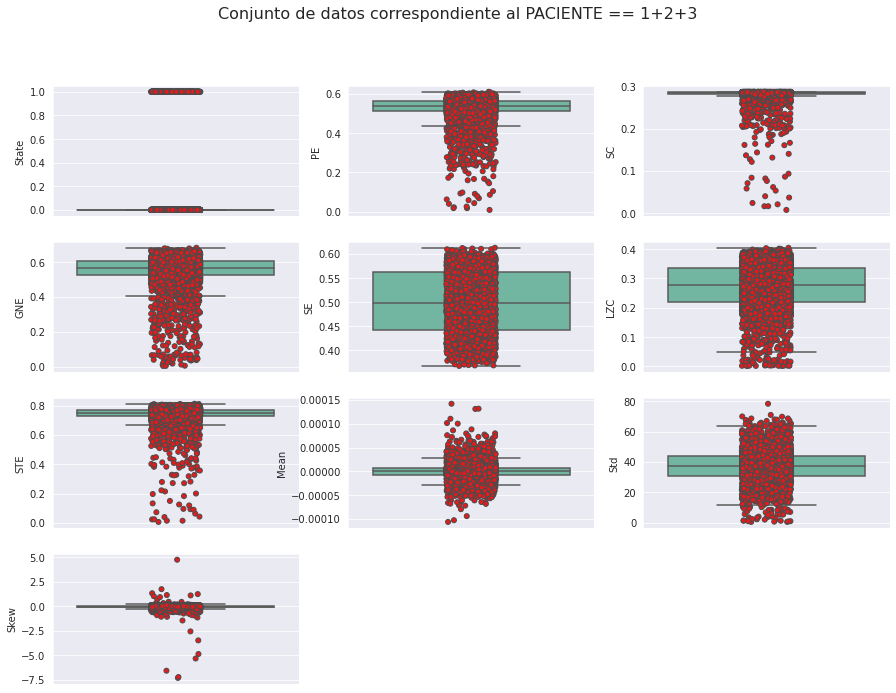

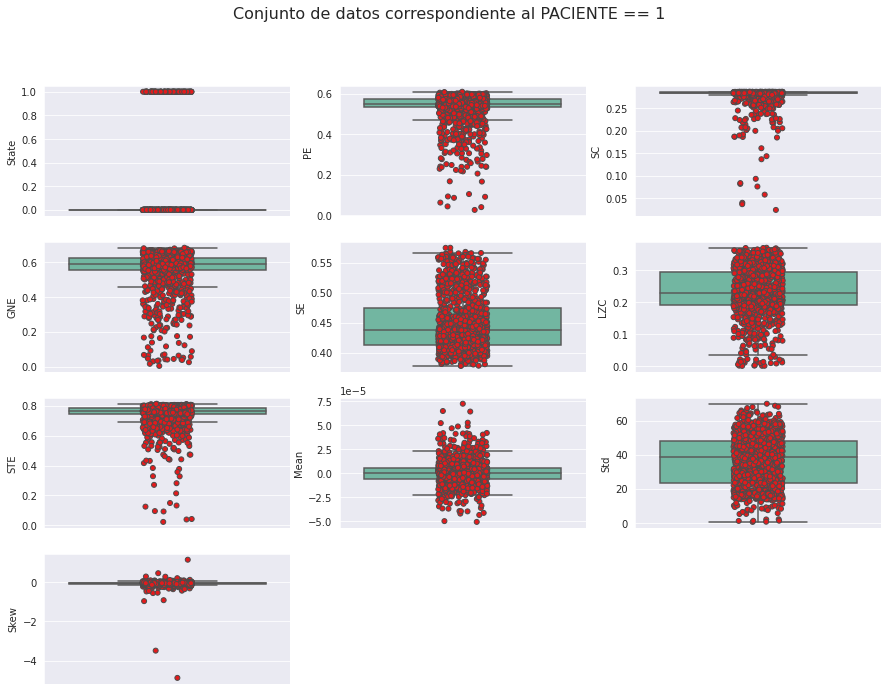

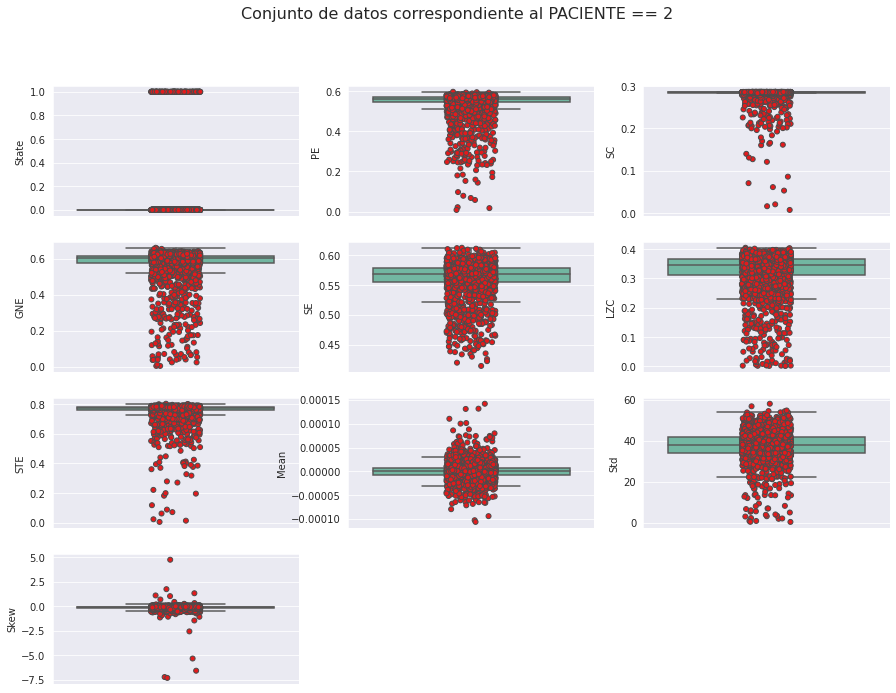

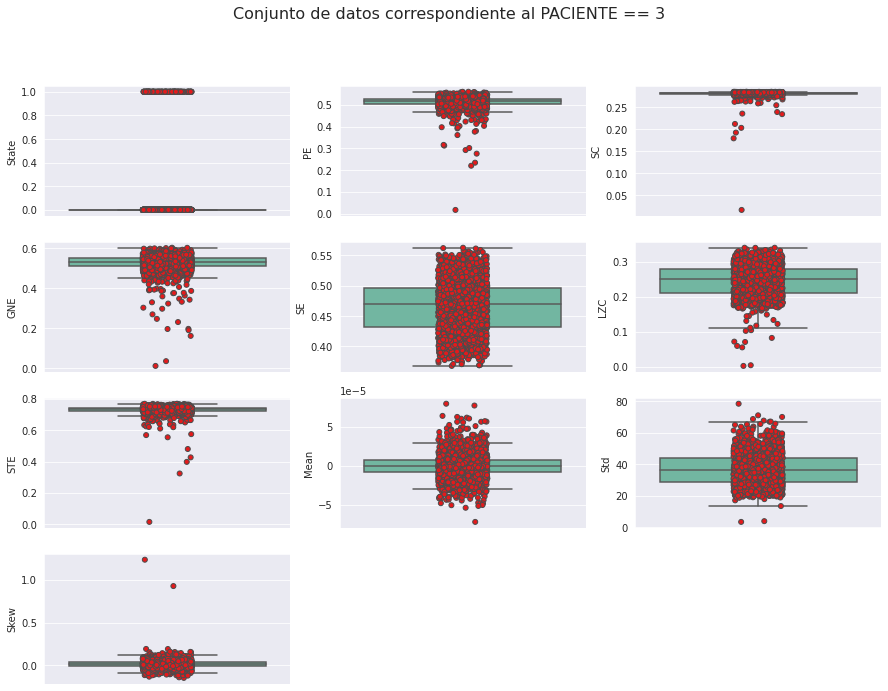

In [131]:
# graficamos los DFs originales (con outliers)-.
cat_cols=['Patient']
nc= 3
[plot_col_out(df_e[i], cat_cols, nc, i) for i in range(len(df_e))]

In [132]:
# OPCION 1 @ eliminar OUTLIERS: tengo problemas porque me saca todos los 1 (unos) del clasificador
# al considerarlos OUTLIERS.
# removemos los outliers
outlier_remover = OutlierRemover() # instanciamos la clase (creamos el objeto)-.

df_e_sin_out= list()
[df_e_sin_out.append(outlier_remover.fit_transform(df_e[i])) for i in range(len(df_e))]

# eliminamos los registros con datos nulos
[eval('df_e_sin_out['+str(i)+']').dropna(axis=0, inplace=True) for i in range(len(df_e_sin_out))]

# [print(df_e[i]['State'].value_counts()) for i in range(len(df_e))]
# [print(df_e_sin_out[i]['State'].value_counts()) for i in range(len(df_e_sin_out))]

[None, None, None, None]

In [133]:
# OPCION 2 @ eliminar outliers: la uso porque la OPCION 1 (uno) no me está funcionando-.
# También me eliminaba todas las filas con 1 (unos), por eso tuve que agregar en la función
# un condicional para que no controle la columna State-.
outlier_tolerance_k = 1.5 # larger means you tolerate more extreme values. For gaussian data, standard is 1.5. 
dfs= list()
for i, data_frame in enumerate(df_e):
    df_filtered = label_outliers_iqr_ac(df_e[i],
                                        k=outlier_tolerance_k,
                                        verbose=True)
    dfs.append(df_filtered)
# [print(dfs[i]['State'].value_counts()) for i in range(len(dfs))]

[None, None, None, None]

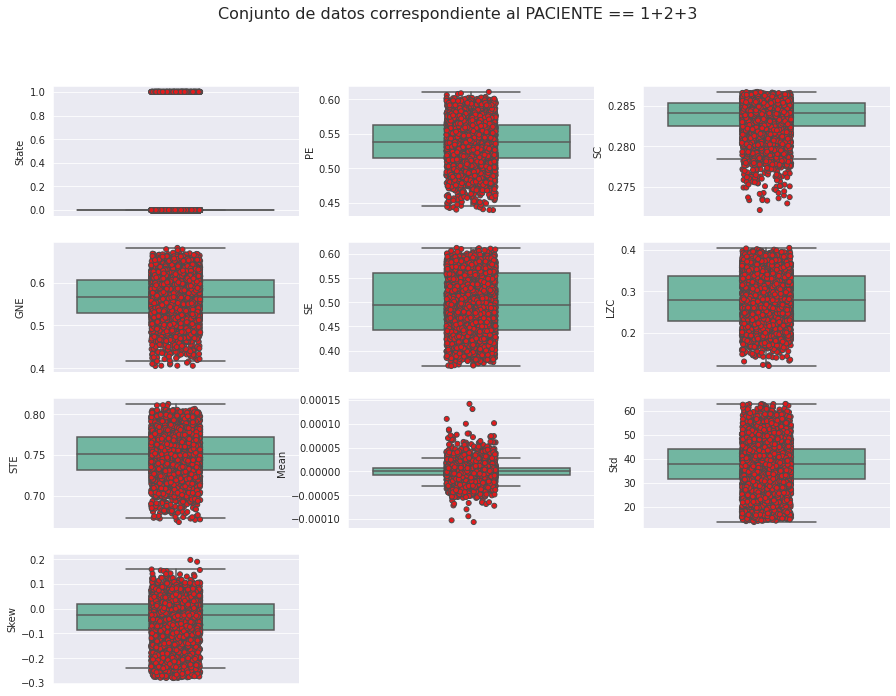

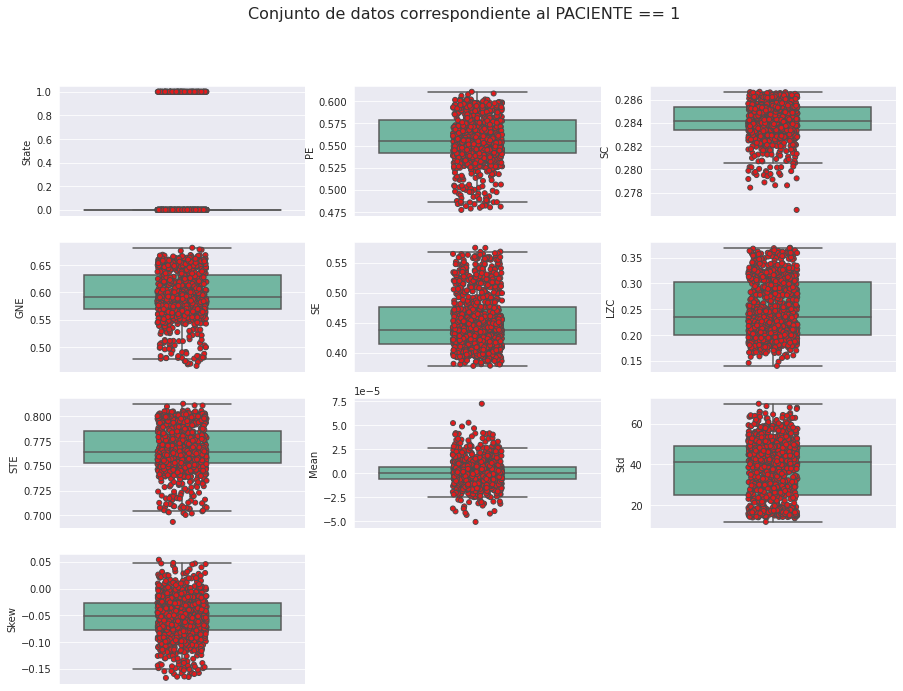

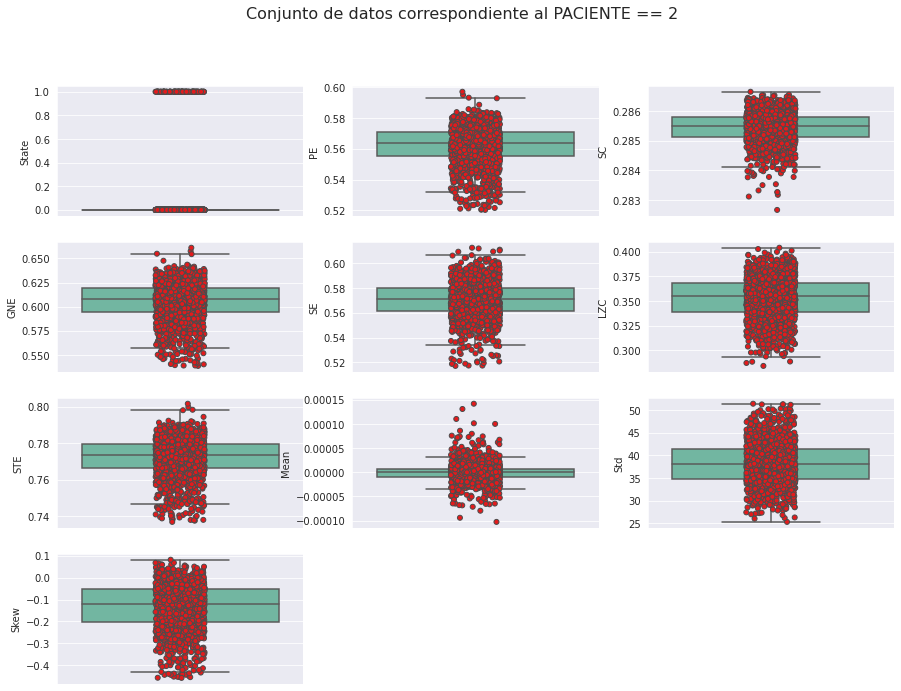

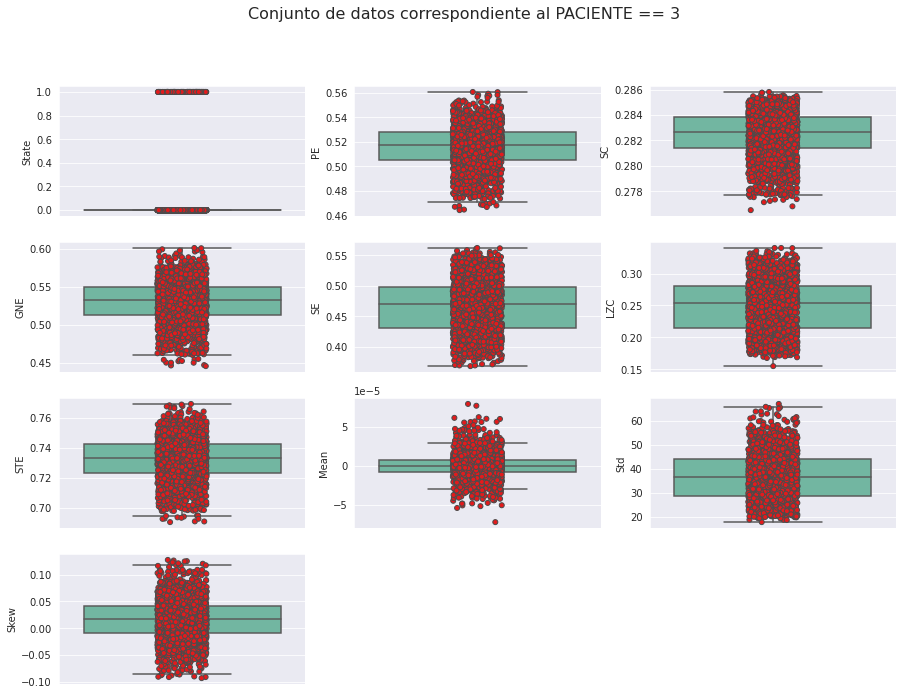

In [134]:
# graficamos los DFs con los Outliers removidos (ver que los DFs almacenados segun opcion 1 o 2, cambia 
# el nombre)-.
cat_cols=['Patient']
nc= 3
# @ OPCION 1
# [plot_col_out(df_e_sin_out[i], cat_cols, nc, i) for i in range(len(df_e_sin_out))]
# @ OPCION 2
[plot_col_out(dfs[i], cat_cols, nc, i) for i in range(len(dfs))]

# Segunda parte: Estudio de clasificadores

#### Consigna: instanciar un modelo inicial que se usará como base para comparar con otros modelos. Usar un modelo lineal (ver archivo de ejemplo)

El modelo base es una primera aproximación. No necesariamente estamos en busqueda de ajustar hiperparametros para incrementar unas decimas el F1-Score, sino que mas bien queremos conocer la performance del modelo en su ajuste mas básico. De esa manera cuando comencemos a ajustar más y usar otros modelos no lineales, sabemos que no deberíamos tener algo peor al base. 

---
#### Consigna: Elegir y justificar un modelo para seleccion de features

Ya se vió que puede existir cierta correlación entre algunas de nuestras features. Para asegurar la efectividad del dataset, vamos a usar algun modelo que prediga cuales son los mejores features.

Fuente: https://towardsdatascience.com/feature-selection-using-logistic-regression-model-efc949569f58

---
#### Consigna: Estudien, prueben, y diagnostiquen distintos clasificadores sobre nuestros set de datos. 

Prueben el dataset etiquetado separando por paciente y con el dataset completo (sin la columna de paciente). Por cada modelo: 

- Aplicar un selector de features
- Estudiar que los hiperparametros se ajusten a nuestro dataset. 
- Refinar la busqueda de hiperparametros usando gridsearchCV o RandomSearchCV (recuerden que mucho antes de los hiperparametros, son los features los que mas determinan la efectividad del modelo). 


Modelos propuestos (no limitarse a):

- Lineal (modelo base): LogisticRegression, SGDClassifier. _Fuente: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model_
- SVM: SVC, NuSVC, LinearSVC. _Fuente: https://scikit-learn.org/stable/modules/svm.html_
- Ensemble:  BaggingClassifier, KNeighborsClassifier, RandomForestClassifier. _Fuente: https://scikit-learn.org/stable/modules/ensemble.html_
- Opcional:
    - Deep Learning: Keras Sequential (ver ejemplo)


Por cada modelo usado deberia haber algun analisis sobre los hiperparametros que mejor se acomodan a nuestro dataset. No es necesario que se limiten a la lista propuesta de metodos. Pero deberia haber como minimo un modelo base, dos de SVM y dos de Ensemble. Pueden opcionalmente usar el VotingClassifier para combinar los resultados de los clasificadores usados en un modelo nuevo

#### Consigna: Armar una grilla de resultados (ver archivo de ejemplo) y realizar conclusiones.

Nota: Recuerden que las conclusiones no son unicamente acerca de cual es el mejor modelo. Cada modelo que instancian sufre una serie de modificaciones que pueden devenir de la teoria o mas bien de la prueba y el error. El resgistro del analisis sobre el desempeño de los modelos nos va a permitir evaluarlos y ubicarlos en el contexto de nuestro dataset particular.


### Instanciamos un modelo inicial que se usará como modelo base

Comenzamos instanciando un modelo báscio lineal cuya métrica sirva de referencia para los puntos posteriores de este entregable. El mismo se aplicará a los cuatro conjuntos de datos que obtuvimos en el punto anterior.

Solo con el fin de poner de manifiesto el desbalanceo de la varibale target, a continuación se analizan la relación de etiquetas en la variable target. 

In [135]:
# Train and validation
# define a function-.
X_train, X_test, y_train, y_test= list(), list(), list(), list()

for i in range(len(dfs)):
    X = dfs[i].drop(labels=['Patient', 'State'], axis=1).copy()
    y = dfs[i]['State'].copy()
    X_t, X_v, y_t, y_v = train_test_split(X,
                                          y,
                                          test_size=0.20,
                                          random_state=42,
                                          shuffle=False
                                         )
    X_train.append(X_t), X_test.append(X_v), y_train.append(y_t), y_test.append(y_v)
    # 
    # list(map(lambda x: x.lower(), ["A", "B", "C"]))
    # filter(upper, mylis)
# check balances in data frames-.

for i in range(len(X_train)):
    print('Balanceo etiquetas @ ENTRENAMIENTO (Paciente {0}) = 0/1 = {1}'.
          format(i, round(y_train[i].value_counts()[0]/y_train[i].value_counts()[1],2)))
    print('Balanceo etiquetas @ TEST (Paciente {0}) = 0/1 = {1}'.
          format(i,round(y_test[i].value_counts()[0]/y_test[i].value_counts()[1],2)))

Balanceo etiquetas @ ENTRENAMIENTO (Paciente 0) = 0/1 = 13.09
Balanceo etiquetas @ TEST (Paciente 0) = 0/1 = 12.16
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 1) = 0/1 = 8.96
Balanceo etiquetas @ TEST (Paciente 1) = 0/1 = 8.22
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 2) = 0/1 = 13.59
Balanceo etiquetas @ TEST (Paciente 2) = 0/1 = 8.64
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 3) = 0/1 = 18.17
Balanceo etiquetas @ TEST (Paciente 3) = 0/1 = 9.48


Ahora se procede a realizar el balanceo en los conjuntos de datos de entrenamiento correspondientes a los pacientes solamente (para evitar el "Data Leakage" https://scikit-learn.org/dev/common_pitfalls.html -metrics overestimation- el balanceo no se aplica al conjunto de datos de test).

In [136]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from imblearn.over_sampling import SMOTE, ADASYN

# smoteenn_=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
rs= 42

# undersampling majority class
undersample_ = RandomUnderSampler(random_state=rs,
                                  sampling_strategy=1.0)
# oversampling minirity class (using smote and adasyn)-.
smote_ = SMOTE(random_state=rs,
               sampling_strategy=1.0) # sampling_strategy = {0: 0.25, 1: 0.75}
adasyn_ = ADASYN(random_state=rs,
                 sampling_strategy='auto')
# Combine Data Undersampling and Oversampling-.
smoteenn_ = SMOTEENN(random_state=rs,
                     sampling_strategy='all')

balancers_list= [undersample_, smote_, adasyn_, smoteenn_]
balancers_names= ['undersample', 'smote', 'adasyn', 'smoteenn']
steps = [('bl', smote_)]
# parameters = { }

pipeline = Pipeline(steps)
# grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

for i in range(len(dfs)):
    print('{0}Paciente {1}'.format('\n',i))
    print('{0:<20}{1:<20}{2:<20}{3:<20}'.format('Balanceador',
                                         'tamaño original',
                                         'nuevo tamaño',
                                         'Balanceo de etiquetas'))
    for j in range(len(balancers_list)):
        len_old = len(y_train[i])
        X_tr, y_tr= balancers_list[j].fit_resample(X_train[i],
                                                   y_train[i]
                                                  )
        print('{0:<20}{1:<20}{2:<20}{3:<20}'.format(balancers_names[j],
                                                    len_old,
                                                    len(y_tr),
                                                    round(y_tr.value_counts()[0]/y_tr.value_counts()[1],2)
                                                   )
             )


Paciente 0
Balanceador         tamaño original     nuevo tamaño        Balanceo de etiquetas
undersample         4313                612                 1.0                 
smote               4313                8014                1.0                 
adasyn              4313                7952                1.02                
smoteenn            4313                5565                0.81                

Paciente 1
Balanceador         tamaño original     nuevo tamaño        Balanceo de etiquetas
undersample         847                 170                 1.0                 
smote               847                 1524                1.0                 
adasyn              847                 1504                1.03                
smoteenn            847                 752                 0.84                

Paciente 2
Balanceador         tamaño original     nuevo tamaño        Balanceo de etiquetas
undersample         1386                190                 1.0       

Como se observa:
1. **Submuestreando** la clase mayoritaria según la clase minoritaria, el tamaño de los conjuntos de datos disminuyen considerablemente perdiendo muchos registros en un conjunto de datos con pcos registros.
2. **Incrementando el muestreo** de la clase minoritaria según la clase mayoritaria tanto con SMOOTE y ADASYN, el tamaño aumenta hasta casi duplicar la cantidad de registros.
3. **Combinando** el **incremento** de la clase minoritaria con  SMOTE y el **submuestreo** con Edited Nearest Neighbors de la clase mayoritaria, el incremento de la cantidad de registros es inermedio entre Undersampling y Oversampling.

En función de lo mencionado y teniendo en cuenta que la dimensión del conjunto de datos es pequeña, se empleará el balanceo con ADASYN. 

In [137]:
for i in range(len(dfs)):
    X_train[i], y_train[i]= adasyn_.fit_resample(X_train[i],y_train[i])
    print('Balanceo etiquetas @ ENTRENAMIENTO (Paciente {0}) = 0/1 = {1}'.
          format(i, round(y_train[i].value_counts()[0]/y_train[i].value_counts()[1],2)))

Balanceo etiquetas @ ENTRENAMIENTO (Paciente 0) = 0/1 = 1.02
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 1) = 0/1 = 1.03
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 2) = 0/1 = 1.01
Balanceo etiquetas @ ENTRENAMIENTO (Paciente 3) = 0/1 = 1.01


Chequeamos si las columnas corrrespondientes a datos continuos y/o de tipo flotante, están normalizados.

In [138]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
for i in range(len(dfs)):
    X= dfs[i].drop(labels=['Patient', 'State'], axis=1)
    vals = pd.DataFrame({'mean': np.mean(X),
                         'var': np.var(X)
                        })

    scaled_features= ss.fit_transform(X)
    scaled_features_df = pd.DataFrame(scaled_features)

    if i==0:
        j='1+2+3'
    else:
        j=i
    print('Paciente {0}{1}{2}'.format(j,'\n',vals))
    print(np.mean(X.to_numpy()))
    print(np.var(X.to_numpy()))
    print(np.mean(scaled_features_df))
    print(np.var(scaled_features_df))
    print(np.mean(scaled_features))
    print(np.var(scaled_features))

Paciente 1+2+3
              mean           var
PE    5.380433e-01  9.284884e-04
SC    2.836428e-01  4.563544e-06
GNE   5.658108e-01  2.446509e-03
SE    4.973934e-01  3.890154e-03
LZC   2.805651e-01  3.841424e-03
STE   7.512920e-01  6.666258e-04
Mean -4.957385e-10  2.668504e-10
Std   3.755070e+01  9.107066e+01
Skew -4.338419e-02  7.047104e-03
4.491562909304454
146.79556321630625
0    3.288336e-15
1   -4.216974e-15
2    7.579661e-16
3   -5.067246e-16
4   -7.655433e-17
5   -6.864769e-17
6   -2.381255e-17
7   -2.823430e-16
8    3.081322e-17
dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
dtype: float64
-1.273114302554004e-16
1.0
Paciente 1
              mean           var
PE    5.573343e-01  6.941646e-04
SC    2.841614e-01  2.108003e-06
GNE   5.961801e-01  1.821296e-03
SE    4.501941e-01  2.218021e-03
LZC   2.490731e-01  3.105484e-03
STE   7.669780e-01  5.115220e-04
Mean  3.733560e-07  1.681758e-10
Std   3.794689e+01  2.076832e+02
Skew -5.35

Como se demostró, los cuatro conjuntos de datos están desbalanceados y no han sido normalizados. Por lo tanto, para definir qué técnica de normalización y selector de features considerar antes de aplicar los diferentes modelos, se procederá de la siguiente manera:
1. Primero se definirá un caso base: para esto, con los datos de entrenamiento balanceados, se normalizarán y se aplicará un modelo de clasificación no lineal correspondiente a la regresión logística.
2. Al caso anterior se le aplicarán otros modelos de normalizado y de selección de features con la finalidad de comparar los resultados obtenidos con el caso base. En este punto se pretende definir con qué normalizador y selector de features correr los diferentes modelos.

Con este procedimiento se busca minimizar los requerimientos y tiempos de cálculos a la hora de aplicar más de un modelo de clasificación.

In [139]:
from imblearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTE, ADASYN

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [140]:
from imblearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTE, ADASYN

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# scalers
scaler_1_ = StandardScaler()
scaler_2_ = MinMaxScaler()
scaler_3_ = RobustScaler()
scalers_= [scaler_1_, scaler_2_, scaler_3_]

model_ = [LogisticRegression()] # base classification model-.

pipeline = Pipeline([
    # the scaler stage is indicated by param_grid-.
    ('ss', 'passthrough'),
    ("clf", model_)
])

param_grid = [
    {
        'ss': scalers_,
        'clf': model_,
        'clf__penalty': ['l1', 'l2'],
        'clf__random_state': [rs],
        'clf__solver': ['liblinear']#,
        #'clf__class_weight': ['balanced'] # if not balance, the model diverge-.
    }
]

model = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error',cv=5)

models= list() # empty list to save metrics obtained with differents data frames-. 
[models.append(model.fit(X_train[i], y_train[i])) for i in range(len(X_train))]
svr_cv= []
for i in range(len(X_train)):
    svr_cv.append(models[i])

In [141]:
# [models[i].best_params_ for i in range(len(X_train))]
# [models[i].best_score_ for i in range(len(X_train))]
[models[i].best_estimator_ for i in range(len(X_train))]

[Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))]),
 Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))]),
 Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))]),
 Pipeline(steps=[('ss', StandardScaler()),
                 ('clf',
                  LogisticRegression(random_state=42, solver='liblinear'))])]

In [142]:
#models= list() # empty list to save metrics obtained with differents data frames-. 
#for i in range(len(X_train)):
#    X_res, y_res = balancer_.fit_resample(X_train[i], y_train[i])
#    models.append(model.fit(X_res, y_res))

In [143]:
from sklearn.metrics import accuracy_score
# predictions (train and test)-.
y_train_pred=  []
y_test_pred= []

[y_train_pred.append(models[i].predict(X_train[i])) for i in range(len(X_train))]
[y_test_pred.append(models[i].predict(X_test[i])) for i in range(len(X_train))]

for i in range(len(X_train)):
    unique, counts = np.unique(y_train_pred[i], return_counts=True)
    #print(dict(zip(unique, counts)))
    print('{0:.3f}'.format(accuracy_score(y_test[i], y_test_pred[i])))

0.604
0.877
0.464
0.818


LogisticRegression - classification repport of TRAIN set
PACIENTE ==> 1+2+3
              precision    recall  f1-score   support

         0.0       0.49      0.62      0.55      4007
         1.0       0.48      0.35      0.41      3945

    accuracy                           0.49      7952
   macro avg       0.49      0.49      0.48      7952
weighted avg       0.49      0.49      0.48      7952

LogisticRegression - classification repport of TEST set
PACIENTE ==> 1+2+3
              precision    recall  f1-score   support

         0.0       0.92      0.63      0.75       997
         1.0       0.07      0.33      0.11        82

    accuracy                           0.60      1079
   macro avg       0.49      0.48      0.43      1079
weighted avg       0.85      0.60      0.70      1079

LogisticRegression - classification repport of TRAIN set
PACIENTE ==> 1
              precision    recall  f1-score   support

         0.0       0.50      0.99      0.67       762
         1.0  

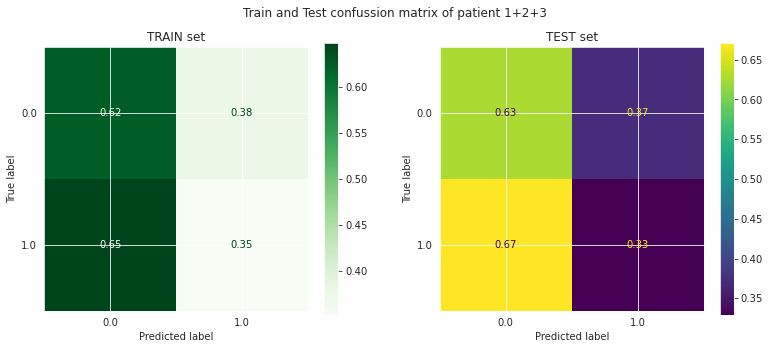

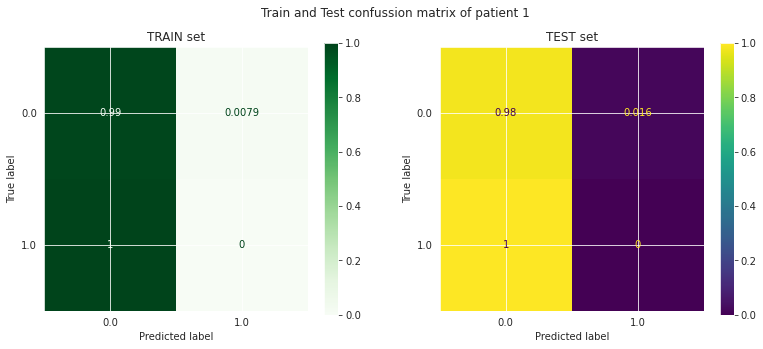

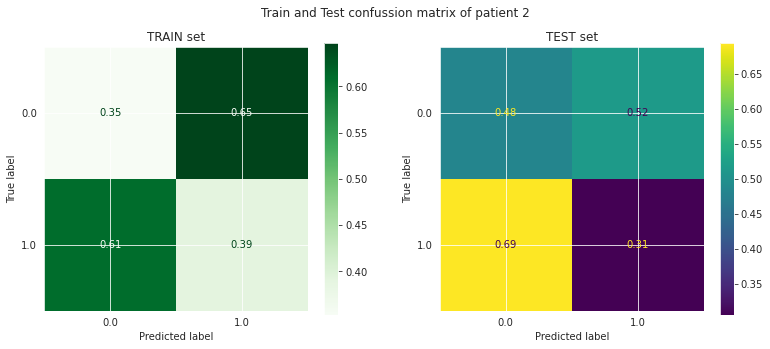

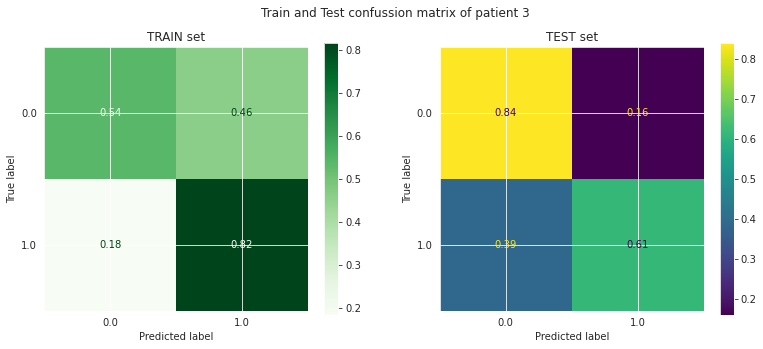

In [144]:
#  evaluamos las predicciones-.
# Evaluate train-.
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for i in range(len(X_train)):
    text = 'LogisticRegression - classification repport of TRAIN set' 
    print(len(text)*"=")
    print(text)
    if i ==0:
        j= '1+2+3'
    else:
        j=i
    print('PACIENTE ==> {0}'.format(j))
    print(len(text)*"=")
    print(metrics.classification_report(y_train[i], y_train_pred[i]))

    # Evaluate val-.
    text= 'LogisticRegression - classification repport of TEST set'
    print(len(text)*"=")
    print(text)
    if i ==0:
        j= '1+2+3'
    else:
        j=i
    print('PACIENTE ==> {0}'.format(j))
    print(len(text)*"=")
    print(metrics.classification_report(y_test[i], y_test_pred[i]))

    fig, axes = plt.subplots(1,2, figsize=(13,5))

    
    #lb= ['0', '1']
    #cm_test = confusion_matrix(y_test[i], y_test_pred[i])
    #cmd = ConfusionMatrixDisplay(cm_test, display_labels=lb)
    #cmd.plot(ax=axes[0],  cmap='viridis')
    
    ConfusionMatrixDisplay.from_predictions(y_train[i],
                                            y_train_pred[i],
                                            normalize='true',
                                            cmap='Greens',
                                            ax=axes[0])
    axes[0].set_title('TRAIN set')
    
    ConfusionMatrixDisplay.from_predictions(y_test[i],
                                            y_test_pred[i],
                                            normalize='true',
                                            cmap='viridis',
                                            ax=axes[1])
    axes[1].set_title('TEST set')
    plt.suptitle("Train and Test confussion matrix of patient {0}".format(j))


Como se oberva: XXXXX.

Entonces:
1. Habiendo definido el balanceo de los conjuntos de datos.
2. Habiendo definido el mejor método de estandarización.

A continuación se emplearán diferentes modelos de selección de features con el fin de analizar si las métricas obtenidas mejoran al aplicar estos transformadores.

In [145]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

In [146]:
# vamos a usar polynomial features sobre las variables numéricas-.
poly = PolynomialFeatures()

In [147]:
num_columns= list(X_train[0].columns.values)
print(type(num_columns))

<class 'list'>


In [148]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [149]:
stsc= StandardScaler()
mmsc= MinMaxScaler()

In [154]:
pipeline = Pipeline([
    ("selector_num", ColumnTransformer([("poly", poly, num_columns),
                                        ('mms', mmsc, num_columns)],
                                       remainder="passthrough")),
    ("classifier", CatBoostClassifier()),
    ])

In [155]:
import scipy.stats as st

In [156]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [157]:
# este diccionario de parámetros lo vamos a usar tanto para XGBoost como para LightGBM
params = {  
    "classifier__n_estimators": st.randint(20,150), # numero de árboles de decision.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
    "classifier__colsample_bytree": one_to_left, # ratio de la muestra de las columnas a la hora de construir el árbol
    "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
    'classifier__reg_alpha': st.uniform(0.05,10),   # término de regularización L1
    "classifier__min_child_weight": st.uniform(1,20), # Suma mínima del peso de la instancia (hessiano) requerida en los hijos
}

In [158]:
other_params = {"selector_num__poly__degree": [1, 2, 3]}   # [1, 2, 3]}
rf_params= { # random forest params-.
    "classifier__n_estimators": st.randint(20,150), # n. de árboles.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__criterion" :['gini', 'entropy'],
    "classifier__random_state" :[rs]
}
sgd_params= { # stochastic gradient descendent params-.
    "classifier__loss": ['log_loss', "perceptron", "squared_error"],
    "classifier__penalty": ["l2", "l1", "elasticnet"],
    "classifier__learning_rate": ['constant', 'optimal', 'invscaling'],
    "classifier__power_t": [0.25,0.5, 1.0],
}
svc_params={ # support vector machine params-.
    "classifier__C": [10**x for x in range(-5, 3)],
    "classifier__kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
    "classifier__gamma": ['scale', 'auto'], # coeficiente @ los Kernels ‘rbf’, ‘poly’ y ‘sigmoid’-.
    "classifier__degree": [1, 2, 3, 4, 5],
}
dtc_params={ # decision tree classifier params-.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__criterion" :['gini', 'entropy'],
    "classifier__splitter": ["best", "random"]
}
etc_params= dtc_params # extra tree classifier params-.

In [159]:
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [160]:
search_space = [{"classifier": [XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)], 
                 **params,
                 **other_params,
                 "classifier__gamma": st.uniform(0, 10) # reducción min de la pérdida @ hacer un split-.
                },
                {"classifier": [LGBMClassifier(n_jobs=3, verbose=-1)],
                 **params,
                 **other_params
                },
                {"classifier": [CatBoostClassifier(thread_count=3, verbose=False)],
                 **other_params,
                 "classifier__n_estimators": st.randint(20,150), # n. de árboles.
                 "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
                 "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
                 "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
                },
                {
                    "classifier": [LogisticRegression(max_iter=10000)],
                    "classifier__C": [10**x for x in range(-5, 3)]
                },
                {
                    "classifier": [RandomForestClassifier()], 
                    **rf_params,
                },
                {
                    "classifier": [SGDClassifier(random_state=rs, max_iter=10000)],
                    **sgd_params,
                },
                {
                    "classifier": [SVC(max_iter=10000, random_state=rs)]
                },
                #{
                #    "classifier": [NuSVC(kernel='poly', max_iter=10000, random_state=rs)]
                #},
                #{
                #    "classifier": [LinearSVC(max_iter=10000, random_state=rs)]
                #},
                {
                    "classifier": [DecisionTreeClassifier(random_state=rs)],
                    **dtc_params,
                },
                {
                    "classifier": [ExtraTreeClassifier(random_state=rs)],
                    **etc_params,
                }
               ]

In [161]:
from sklearn.model_selection import RandomizedSearchCV

In [162]:
scoring = ['neg_mean_squared_error', 'f1', 'precision', 'recall', 'accuracy', 'roc_auc']
model = RandomizedSearchCV(pipeline, search_space, n_iter=100, scoring='neg_mean_squared_error', verbose=1, cv=3)

In [163]:
models= list() # empty list to save metrics obtained with differents data frames-. 
[models.append(model.fit(X_train[i], y_train[i])) for i in range(len(X_train))]

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[None, None, None, None]

In [164]:
# guardamos los resultados
results = pd.DataFrame(model.cv_results_)

In [165]:
# el mejor modelo es
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=3),
                                                  ['PE', 'SC', 'GNE', 'SE',
                                                   'LZC', 'STE', 'Mean', 'Std',
                                                   'Skew']),
                                                 ('mms', MinMaxScaler(),
                                                  ['PE', 'SC', 'GNE', 'SE',
                                                   'LZC', 'STE', 'Mean', 'Std',
                                                   'Skew'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7ff15e264b20>)])

In [166]:
y_predicted=[]
[y_predicted.append(model.predict_proba(X_test[i])) for i in range(len(X_train))]

[None, None, None, None]

In [167]:
from sklearn.metrics import roc_auc_score

In [168]:
[print(np.round(roc_auc_score(y_test[i], y_predicted[i][:,1]),3)) for i in range(len(X_train))]

0.738
0.757
0.548
0.649


[None, None, None, None]

In [169]:
from scikitplot.metrics import plot_roc

<Figure size 1440x2880 with 0 Axes>

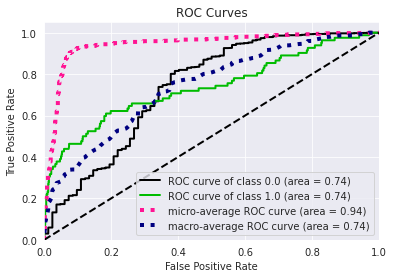

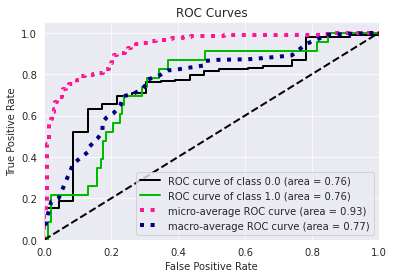

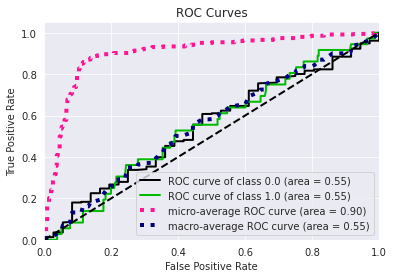

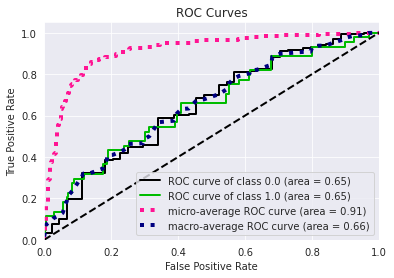

In [170]:
fig= plt.figure(figsize=(20,40))
for i in range(len(X_train)):
    # ax= fig.add_subplot(len(X_train), 1, i+1)
    plot_roc(y_test[i], y_predicted[i])
    # title= 'Paciente {0}'.format(i)
    # ax.set_title(title)
plt.show()

In [171]:
from sklearn.metrics import classification_report
[print(classification_report(y_test[i], np.argmax(y_predicted[i], axis=1))) for i in range(len(X_train))]

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       997
         1.0       0.41      0.38      0.39        82

    accuracy                           0.91      1079
   macro avg       0.68      0.67      0.67      1079
weighted avg       0.91      0.91      0.91      1079

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90       189
         1.0       0.20      0.22      0.21        23

    accuracy                           0.82       212
   macro avg       0.55      0.56      0.55       212
weighted avg       0.83      0.82      0.82       212

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       311
         1.0       0.00      0.00      0.00        36

    accuracy                           0.87       347
   macro avg       0.45      0.49      0.47       347
weighted avg       0.80      0.87      0.83       347

              preci

[None, None, None, None]